## Parsing : Document to CSV

In [3]:
import os
import csv
from PyPDF2 import PdfReader

INPUT_DIR = 'papers_adhd'
OUTPUT_DIR = 'papers_adhd_csvs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

output_csv = os.path.join(OUTPUT_DIR, 'all_papers.csv')

with open(output_csv, mode='w', encoding='utf-8', newline='') as csvfile:
    writer = csv.writer(
        csvfile,
        quoting=csv.QUOTE_MINIMAL,    # only quote fields when needed
        quotechar='"',                # wrap fields containing special chars in "
        escapechar='\\'               # escape embedded quotechars with backslash
    )
    writer.writerow(['page_text', 'source_file', 'page_number'])

    for fname in os.listdir(INPUT_DIR):
        if not fname.lower().endswith('.pdf'):
            continue

        pdf_path = os.path.join(INPUT_DIR, fname)
        try:
            reader = PdfReader(pdf_path)
        except Exception as e:
            print(f'[!] Could not open "{fname}": {e}')
            continue

        for page_num, page in enumerate(reader.pages, start=1):
            try:
                text = page.extract_text() or ''
            except Exception as e:
                text = f'[Error on page {page_num}: {e}]'

            # remove any null bytes that can break the CSV writer
            text = text.replace('\x00', '')

            writer.writerow([text, fname, page_num])

        print(f'  → Processed "{fname}" ({len(reader.pages)} pages)')

print(f'All done! Combined CSV written to:\n  {output_csv}')


  → Processed "paper1.pdf" (28 pages)
  → Processed "paper10.pdf" (2 pages)
  → Processed "paper11.pdf" (3 pages)
  → Processed "paper12.pdf" (13 pages)
  → Processed "paper13.pdf" (28 pages)
  → Processed "paper14.pdf" (13 pages)
  → Processed "paper15.pdf" (13 pages)
  → Processed "paper16.pdf" (17 pages)
  → Processed "paper17.pdf" (15 pages)
  → Processed "paper18.pdf" (22 pages)
  → Processed "paper19.pdf" (11 pages)
  → Processed "paper2.pdf" (14 pages)
  → Processed "paper20.pdf" (8 pages)
  → Processed "paper21.pdf" (24 pages)
  → Processed "paper3.pdf" (13 pages)
  → Processed "paper4.pdf" (15 pages)
  → Processed "paper5.pdf" (11 pages)
  → Processed "paper6.pdf" (9 pages)
  → Processed "paper7.pdf" (6 pages)
  → Processed "paper8.pdf" (11 pages)
  → Processed "paper9.pdf" (4 pages)
All done! Combined CSV written to:
  papers_adhd_csvs\all_papers.csv


## Understanding Data

In [9]:
import pandas as pd

# df= pd.read_csv(r"papers_adhd_csvs/all_papers.csv", encoding='utf-8', escapechar='\\')
# df['page_text'] = df['page_text'].str.replace(r'\\', '', regex=True)

df= pd.read_csv(r"papers_adhd_csvs/all_papers.csv", encoding='utf-8')

print(f'Number of rows: {len(df)}')
print(f'Number of columns: {len(df.columns)}')
print(f'Columns: {df.columns.tolist()}')

print(f'First 5 rows:\n{df.head()}')

max_length = df['page_text'].str.len().max()
print(f'Max length of page_text: {max_length}')

max_length = df['page_text'].str.len().mean()
print(f'Mean length of page_text: {max_length}')

Number of rows: 280
Number of columns: 3
Columns: ['page_text', 'source_file', 'page_number']
First 5 rows:
                                           page_text source_file  page_number
0  Exploring N-Back Cognitive Training for Childr...  paper1.pdf            1
1  prevalence of ADHD, the chances are high that ...  paper1.pdf            2
2  these interventions, teachers (behavioral clas...  paper1.pdf            3
3  inhibition and working memory-demanding execut...  paper1.pdf            4
4  learning or attention disorders. Based on our ...  paper1.pdf            5
Max length of page_text: 10525
Mean length of page_text: 3987.3107142857143


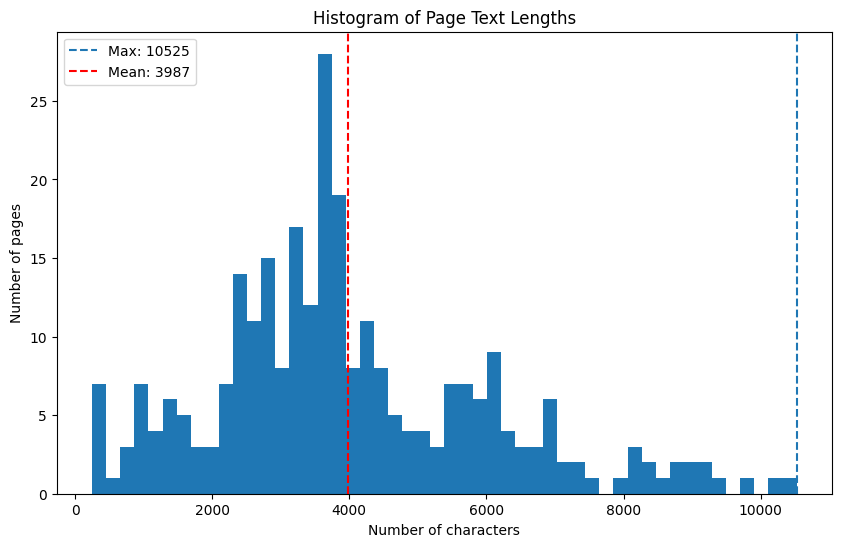

Max length of page_text: 10525
Mean length of page_text: 3987.31


In [ ]:
# Histogram of page_text lengths
import matplotlib.pyplot as plt
# Compute the length of each page's text
lengths = df['page_text'].astype(str).str.len()

# Plot a histogram of those lengths
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50)
plt.title('Histogram of Page Text Lengths')
plt.xlabel('Number of characters')
plt.ylabel('Number of pages')

# Mark the max and mean
max_len = lengths.max()
mean_len = lengths.mean()
plt.axvline(max_len, linestyle='--',  label=f'Max: {max_len:.0f}')
plt.axvline(mean_len, linestyle='--',color='r', label=f'Mean: {mean_len:.0f}')
plt.legend()

plt.show()

# Print out the numeric stats
print(f'Max length of page_text: {max_len}')
print(f'Mean length of page_text: {mean_len:.2f}')







## Chunking

In [14]:
import os
import pandas as pd
from semchunk import chunkerify
from transformers import AutoTokenizer, AutoModel

# Paths
INPUT_CSV  = 'papers_adhd_csvs/all_papers.csv'
OUTPUT_CSV = 'papers_adhd_csvs/all_papers_chunked.csv'

# Load data
df = pd.read_csv(INPUT_CSV, encoding='utf-8')
df['page_text'] = df['page_text'].astype(str)

# Initialize ClinicalBERT tokenizer & model (model not used for token counting)
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
model     = AutoModel.from_pretrained("medicalai/ClinicalBERT")

# Initialize semantic chunker: ~1000‑token chunks
chunker = chunkerify(
    model_name='gpt-4',
    chunk_size=1000,
    max_token_chars=None
)

chunked_rows = []

for _, row in df.iterrows():
    text = row['page_text']
    # count tokens using ClinicalBERT tokenizer
    tok_ids = tokenizer.encode(text, add_special_tokens=False)
    
    if len(tok_ids) > 5000:
        # chunk large documents
        chunks = chunker([text])[0]
        for c in chunks:
            chunked_rows.append({
                'chunk': c,
                'source_file': row.get('source_file', ''),
                'page_number': row.get('page_number', None)
            })
    else:
        # leave small documents intact
        chunked_rows.append({
            'chunk': text,
            'source_file': row.get('source_file', ''),
            'page_number': row.get('page_number', None)
        })

# Save to new CSV
chunked_df = pd.DataFrame(chunked_rows, columns=['chunk','source_file','page_number'])
chunked_df.to_csv(OUTPUT_CSV, index=False, encoding='utf-8')

print(f"✅ Chunked data saved to {OUTPUT_CSV}")


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

C:\Users\mkolla1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mkolla1\.cache\huggingface\hub\models--medicalai--ClinicalBERT. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

C:\Users\mkolla1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:653: UserWarning: Not enough free disk space to download the file. The expected file size is: 541.83 MB. The target location C:\Users\mkolla1\.cache\huggingface\hub\models--medicalai--ClinicalBERT\blobs only has 169.73 MB free disk space.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/542M [00:00<?, ?B/s]

OSError: [Errno 28] No space left on device